<img src="https://user-images.githubusercontent.com/52746337/166633507-8610f330-cb2c-449c-8ca1-faecce779a54.png" width="400" align="center">

<h1><center>IBM-AWS Immersion Day Lab 4<br><br>Notebook 1 : Predict future COVID-19 cases for Brussels region with Long Short-Term Memory (LSTM) Model</center></h1>

In this lab exercise, you will learn a popular opensource machine learning algorithm, Long Short-Term Memory (LSTM). You will use this time-series algorithm to build a model from historical data of total COVID-19 cases. Then you use the trained model to predict the future COVID-19 cases.

### Install/upgrade required packages

In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-gpu

In [ ]:
!pip install keras==2.7.0

>NOTE: Restart the Kernel after installing/upgrading the packages. Goto **Kernel > Restart**.

### Import required libraries

In [1]:
import boto3
import numpy as np 
import pandas as pd 
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import math, time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.callbacks import EarlyStopping
import tensorflow
from io import StringIO
import datetime
import io
import itertools
from project_lib import Project
project = Project.access()
%matplotlib inline

### Load the dataset from Amazon S3 into pandas dataframe



- Click on **find and add data (0100)** button on top right. 
- Click on **Connections** tab.
- You will see your connection variable. Click on **Insert to code** and select **pandas DataFrame**.
- Select the **ts-brussels-grouped.csv** dataset from the connection variable.

>Note: you can add the comment `# @hidden_cell` in the below code cell. Cloud Pak for Data will automatically hide the cell before sharing it.

DATE    REGION  Total_cases
0  15/03/20  Brussels          119
1  16/03/20  Brussels          238
2  17/03/20  Brussels          219
3  18/03/20  Brussels          346
4  19/03/20  Brussels          583
5  20/03/20  Brussels          504
6  21/03/20  Brussels          683
7  22/03/20  Brussels          719
8  23/03/20  Brussels          515
9  24/03/20  Brussels         1058

In [3]:
regionData = data_df_1

#### Drop REGION column

In [4]:
data_df_1 = data_df_1.drop('REGION', axis=1)

#### Drop the index column and set DATE column as index column

In [5]:
data_df_1.set_index('DATE', inplace=True)

### Fix random seed for reproducibility

In [6]:
tensorflow.random.set_seed(1309)

### Rename the dataframe and convert the datatype

In [7]:
series = data_df_1
series = series.astype(float)

### Plot the data to see the current trends in COVID-19 cases in Brussels Region

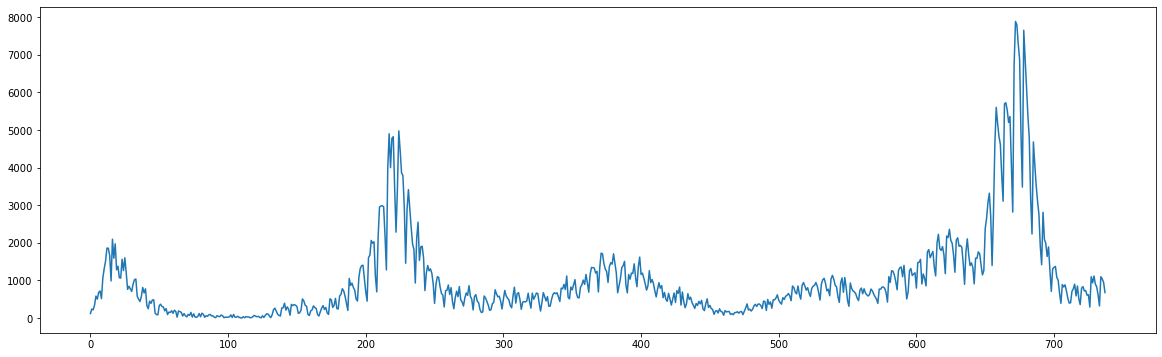

In [8]:
plt.figure(figsize=(20,6))
plt.plot(series.values)
plt.show()

### Normalize the data

In [9]:
series = series.values
scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(series)

### Train Test Split 70:30 Ratio

In [10]:
train_size = int(len(series) * 0.70)
test_size = len(series) - train_size
train, test = series[0:train_size,:], series[train_size:len(series),:]
print(len(train), len(test))

516 222


### Helper function to generate the dataset with input(X) & output(Y) variables

In [11]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### Create a dataset with a look back period of 30 observations
This is where we convert the time series problem into a regression problem

In [12]:
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

### Review the shape of datasets

In [13]:
trainX.shape

(485, 30)

In [14]:
testX.shape

(191, 30)

### Reshape the data to 3D
The LSTM model requires the input data to be three dimensional

In [15]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [16]:
trainX.shape

(485, 30, 1)

### Define the LSTM model
Activation function will activate the neurons for the learning. Rectified linear unit (ReLu) is one of the most popular activations because the output does not go beyond 0.

Units will be the number of neurons in the input & hidden layers.

Stateful is where we define whether the previous information has to be remembered or not.

Dropout is where we omit random neurons for each layer as per the value (0 to 1). In this case we omit 20% of the neurons.

Optimiser is where the weights are back propagated through the network to enhance the learnings closer to the desired outcome. Adam optimiser is an efficient method for enhanced accuracy.

Hyperparameters for the current model:
- **train_test_split:** 0.70
- **lookback:** 30
- **hidden_layers:** 2
- **units:** 55, 100
- **dropouts:** 0.15, 0.15
- **optimizer:** adam
- **learning_rate:** 0.001 (default)
- **epochs:** 25
- **batch_size:** 32

In [17]:
print('LSTM Model Summary')
model = Sequential()
model.add(LSTM(input_shape=(trainX.shape[1], trainX.shape[2]), kernel_initializer="uniform", return_sequences=True, stateful=False, units=55))
model.add(Dropout(0.15))
model.add(LSTM(100, kernel_initializer="uniform", activation='relu',return_sequences=False))
model.add(Dropout(0.15))
model.add(Dense(32,kernel_initializer="uniform",activation='relu'))
model.add(Dense(1, activation='linear'))
# optimizer = Adam(learning_rate=0.0005)
# model.compile(loss="mean_squared_error", optimizer=optimizer)
model.compile(loss="mean_squared_error", optimizer='adam')
model.summary()

LSTM Model Summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 55)            12540     
                                                                 
 dropout (Dropout)           (None, 30, 55)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               62400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 78,205
Trainable params

### Parameter Calculation
params = 4 * (size_of_input + 1 * size_of_output) + 4 * size_of_output^2



### Optimize computation time using early stopping

We monitor the accuracy of validation loss ('val_loss') and end the training if there's no improvement in the accuracy after five iterations ('patience=5').

In [18]:
early_stopping=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

### Fitting the model for training data

In [19]:
start = time.time()
history = model.fit(trainX, trainY, batch_size=32, epochs=25, verbose=1, shuffle=False, validation_split=0.10, callbacks=[early_stopping])
print("> Compilation Time : ", time.time() - start)

Epoch 1/25
14/14 [==============================] - 9s 377ms/step - loss: 0.0142 - val_loss: 0.0019
Epoch 2/25
14/14 [==============================] - 4s 313ms/step - loss: 0.0108 - val_loss: 0.0033
Epoch 3/25
14/14 [==============================] - 4s 308ms/step - loss: 0.0106 - val_loss: 0.0023
Epoch 4/25
14/14 [==============================] - 4s 316ms/step - loss: 0.0099 - val_loss: 0.0023
Epoch 5/25
14/14 [==============================] - 4s 309ms/step - loss: 0.0083 - val_loss: 7.4788e-04
Epoch 6/25
14/14 [==============================] - 4s 316ms/step - loss: 0.0068 - val_loss: 5.4045e-04
Epoch 7/25
14/14 [==============================] - 4s 308ms/step - loss: 0.0051 - val_loss: 4.2679e-04
Epoch 8/25
14/14 [==============================] - 4s 308ms/step - loss: 0.0048 - val_loss: 2.6871e-04
Epoch 9/25
14/14 [==============================] - 4s 307ms/step - loss: 0.0043 - val_loss: 3.2288e-04
Epoch 10/25
14/14 [==============================] - 4s 309ms/step - loss: 0.005

Model run time is ~ 300 seconds and has produced almost similar values for training & validation loss which is great.

### Create a function to calculate accuracy
We will be using 'Mean Squared Error' & 'Root Mean Squared Error' functions to calculate accuracy

In [20]:
def model_score(model, trainX, trainY, testX, testY):
    trainScore = model.evaluate(trainX, trainY, batch_size=32, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    print('Train Accuracy: %.2f %%' % (100 - math.sqrt(trainScore)*100))

    testScore = model.evaluate(testX, testY, batch_size=32, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
    print('Test Accuracy: %.2f %%' % (100 - math.sqrt(testScore)*100))
    return trainScore, testScore

### Check the Accuracy of the model

In [21]:
model_score(model, trainX, trainY, testX, testY)

Train Score: 0.00165 MSE (0.04 RMSE)
Train Accuracy: 95.93 %
Test Score: 0.00987 MSE (0.10 RMSE)
Test Accuracy: 90.07 %


(0.001654056366533041, 0.009867317043244839)

We can observe that the Root Mean Squared Error (RMSE) values are almost similar for training & test data which confirms the accuracy of the model without overfitting or underfitting.

The model accuracy is > 94% as per the values of Mean Squared Error (MSE)

### Review the learning of training & validation loss (error evaluation)

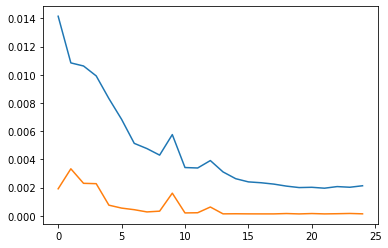

In [22]:
'''Review the learning'''

plt.plot(history.history['loss']) # Train
plt.plot(history.history['val_loss']) # Test
plt.show()

There's no vanishing gradient descent as the LSTM model with optimal configueration has taken care of the gradient descent problem.

### Get the configuration of the model
This will give us an idea about all the parameters available and which ones have been choosen.

In [23]:
model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 30, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'lstm_input'}},
  {'class_name': 'LSTM',
   'config': {'name': 'lstm',
    'trainable': True,
    'batch_input_shape': (None, 30, 1),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 55,
    'activation': 'tanh',
    'recurrent_activation': 'hard_sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
  

### Create a function to plot predicted vs actual values 

In [24]:
def plot_the_results(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(16,8))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.plot(padding + data, 'b^')
    plt.show()

### Create a function to predict future values

In [25]:
def predict_the_sequences(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

### Predict future values & plot the results
   In this case, we are predicting the current values.
   If we need to predict t+1 then the prediction_len parameter has to be changed to 2
   and if we need t+2 then prediction_len would be 3

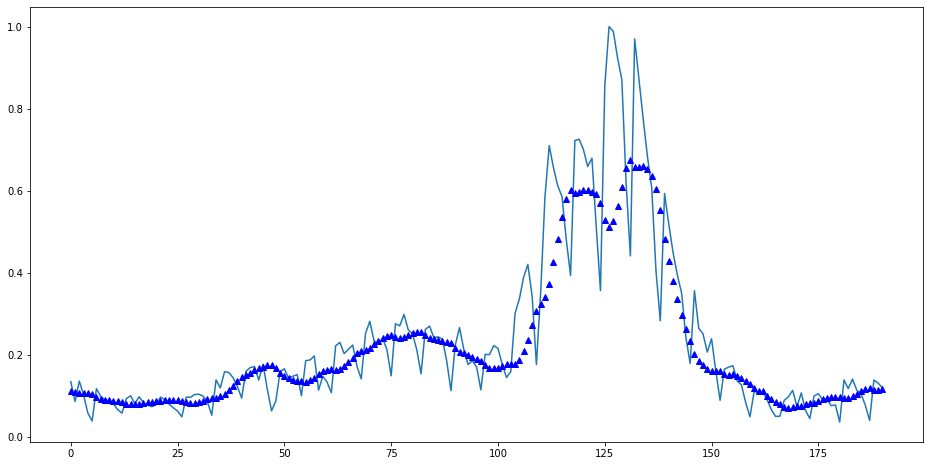

In [26]:
predictions = predict_the_sequences(model, testX, look_back, 1)

plot_the_results(predictions, testY, 1)

We can observe that the model is able to catch the pattern in the data. This can be further improved by changing the hyper parameters however we are demonstrating the methodology.

### Predictions for next 7 days

In [27]:
predictions7 = predict_the_sequences(model, testX, look_back, 7)

### Denormalize the predicted values and save the data
Denormalize & Convert the predicted output to a dataframe & print the results

In [28]:
predictionValues = scaler.inverse_transform(predictions7)
results = pd.DataFrame(np.round(predictionValues[-1:]))

In [29]:
results_list = results.values.tolist()

In [30]:
results_list = [int(i) for i in results_list[0]]

In [31]:
last_date = data_df_1.iloc[-1].name
lastDate = datetime.datetime(int(last_date.split('/')[2]), int(last_date.split('/')[1]), int(last_date.split('/')[0]))
next_date = lastDate + datetime.timedelta(days=1)
next_date = next_date.strftime('%d/%m/%y')

In [32]:
next_7_days = pd.date_range(start=next_date, periods=7, freq='D')
next_7_days_df = pd.DataFrame({'DATE': next_7_days.tolist(), 'Prediction': results_list})

In [33]:
next_7_days_df['DATE'] = next_7_days_df['DATE'].dt.strftime('%d/%m/%y')

In [34]:
next_7_days_df.set_index('DATE', inplace=True)

In [35]:
finalDf = pd.DataFrame(data_df_1.tail(7))

In [36]:
next_7_days_df.reset_index()

DATE  Prediction
0  25/03/22         754
1  26/03/22         773
2  27/03/22         783
3  28/03/22         794
4  29/03/22         805
5  30/03/22         823
6  31/03/22         842

In [37]:
finalDf.reset_index()

DATE  Total_cases
0  18/03/22          830
1  19/03/22          613
2  20/03/22          321
3  21/03/22         1098
4  22/03/22         1039
5  23/03/22          949
6  24/03/22          677

In [38]:
next_7_days_df = next_7_days_df.astype({'Prediction': int})

In [39]:
finalDf = finalDf.astype({'Total_cases': int})

In [40]:
next_7_days_df.to_csv('_buffer_next7.csv')
finalDf.to_csv('_buffer_actual7.csv')

In [41]:
next_7_days_df = pd.read_csv('_buffer_next7.csv')
finalDf = pd.read_csv('_buffer_actual7.csv')

In [42]:
next_7_days_df['DATE'] = pd.to_datetime(pd.Series(next_7_days_df['DATE']), format="%d/%m/%y")
finalDf['DATE'] = pd.to_datetime(pd.Series(finalDf['DATE']), format="%d/%m/%y")

In [43]:
finalDf = pd.concat([finalDf,next_7_days_df], axis=1)

### Store the prediction data to Amazon S3 and Cloud Pak for Data Project Assets

In [44]:
filename = 'brussels-next7Prediction.csv'

In [45]:
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()
AWS_S3_credentials = wslib.get_connection(AWS_S3_data_request['connection_name'])

In [46]:
s3 = boto3.resource(
    service_name = "s3",
    region_name = AWS_S3_credentials['region'],
    aws_access_key_id = AWS_S3_credentials['access_key'],
    aws_secret_access_key = AWS_S3_credentials['secret_key']
)

In [47]:
bucket = AWS_S3_credentials['bucket']
csv_buffer = StringIO()
next_7_days_df.to_csv(csv_buffer, index=False)
s3.Object(bucket, "model_output/"+filename).put(Body=csv_buffer.getvalue())
csv_buffer = StringIO()

In [48]:
next_7_days_df.to_csv(filename, index=False)

with open(filename, 'rb') as z:
        data = io.BytesIO(z.read())
        project.save_data(filename, data, set_project_asset=True, overwrite=True)

### Store Model Loss Data to S3 and Assets

In [49]:
errorevaluation = pd.DataFrame({'index': [int(i) for i in range(len(history.history['loss']))], 'loss': history.history['loss'], 'val_loss': history.history['val_loss']})

In [50]:
errorFilename = 'brussels-errorEvaluation.csv'

In [ ]:
csv_buffer = StringIO()
errorevaluation.to_csv(csv_buffer, index=False)
s3.Object(bucket, "model_output/"+errorFilename).put(Body=csv_buffer.getvalue())

In [52]:
errorevaluation.to_csv(errorFilename, index=False)

with open(errorFilename, 'rb') as z:
        data = io.BytesIO(z.read())
        project.save_data(errorFilename, data, set_project_asset=True, overwrite=True)

### Store Actual vs Predicted Data to S3 and Assets

In [53]:
actualVsPredicted = pd.DataFrame({'index': [int(i) for i in range(len(predictions))], 'actual': testY, 'prediction': list(itertools.chain.from_iterable(predictions))})

In [54]:
actualVsPredictedFilename = 'brussels-actualVsPredicted.csv'

In [ ]:
csv_buffer = StringIO()
actualVsPredicted.to_csv(csv_buffer, index=False)
s3.Object(bucket, "model_output/"+actualVsPredictedFilename).put(Body=csv_buffer.getvalue())

In [56]:
actualVsPredicted.to_csv(actualVsPredictedFilename, index=False)

with open(actualVsPredictedFilename, 'rb') as z:
        data = io.BytesIO(z.read())
        project.save_data(actualVsPredictedFilename, data, set_project_asset=True, overwrite=True)

<h2>Want to learn more?</h2>

The AutoAI graphical tool in Watson Studio analyzes your data and discovers data transformations, algorithms, and parameter settings that work best for your predictive modeling problem. AutoAI displays the results as model candidate pipelines ranked on a leaderboard for you to choose from.

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this Lab!</h3>

<h4>Author:  <a href="https://linkedin.com/in/manojjahgirdar">Manoj Jahgirdar</a> & <a href="https://www.linkedin.com/in/sharath-kumar-rk-52aa2562/"> Sharath Kumar RK</a></h4>
